## Ploting results from feature compression datasets

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

### BLAT Ostermeier 2014

In [ ]:
# Once we have all the fasta files and metadata we can extract the embeddings for each fasta.
python scripts/extract.py esm2_t30_150M_UR50D data/sumo1_human_data.fasta embeddings/sumo1_esm2_150M --repr_layers 30 --include bos mean per_tok


# Then we can compress the embeddings with the following command
dir_path = 'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M/'
for i in ['mean', 'bos', 'max_pool', 'pca1', 'pca2', 'pca1-2', 'iDCT', 'rbf1', 'sigmoid1']:
    print(f'Compressing embeddings using {i}')
    embed = load_per_tok_embeds(dir_path, i)
    with open(f'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed/BLAT_ECOLX_Ostermeier2014_esm2_150M_{i}.pkl', 'wb') as f:
        pickle.dump(embed, f)


# or one by one, but will take too long
python scripts/compressing_embeddings_v02.py  -e embeddings/sumo1_esm2_150M -c mean -l 30


# or by using the following command, see the script for more details
bash run_compression.sh


# with the compressed embedding we can run the regression model, see script for more details
python scripts/run_reg_Lasso.py -i embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed -m data/BLAT_ECOLX_Ostermeier2014_metadata_v02.csv -o results/BLAT_ECOLX_Ostermeier2014_esm2_150M_layer_30_compressed.csv

In [ ]:
# checking corrupted files
path_compressed_embeds = 'embeddings/PABP_YEAST_Fields2013_doubles_esm2_150M_compressed'
for file in os.listdir(path_compressed_embeds):
    if file.endswith('.pkl'):
        method = file.split('_')[-1].split('.')[0]
        print('\nResults for method:', method)
        file_path = os.path.join(path_compressed_embeds, file)
        embed = pd.read_pickle(file_path)
        embed_df = pd.DataFrame.from_dict(embed, orient='index').reset_index()
        embed_df.rename(columns={'index': 'ID'}, inplace=True)

## Results

In [2]:
def plot_results(res_path):
    results = pd.read_csv(res_path, index_col=0)
    results.sort_values('Compression_methd', inplace=True)
    title = ' '.join(res_path.split('/')[-1].split('_')[:-5])
    plt.figure(figsize=(8, 3))
    sns.barplot(data=results, x='Compression_methd', y='R2_score_test')
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel('R2 Score')
    plt.xlabel('Compression methd')
    plt.show()

In [4]:
def plot_results2(res_path):
    results = pd.read_csv(res_path, index_col=0)
    results.sort_values('Compression_methd', inplace=True)
    title = ' '.join(res_path.split('/')[-1].split('_')[:-5])
    plt.figure(figsize=(8, 3))
    sns.barplot(data=results, x='Compression_methd', y='rho_score_test')
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel('rho Score')
    plt.xlabel('Compression methd')
    plt.show()

In [ ]:
count=0
base_path = 'results/regression_L1_5e-3'
for file in os.listdir(base_path):
    count+=1
    print(count)
    file_path = os.path.join(base_path, file)

    plot_results(file_path)

In [ ]:
count=0
base_path = 'results/idct2'
for file in os.listdir(base_path):
    count+=1
    print(count)
    file_path = os.path.join(base_path, file)

    plot_results(file_path)

## Merging files

In [65]:
base_path = 'results/regression_L1_1e-3'
data = pd.DataFrame()
for file in os.listdir(base_path):
    file_path = os.path.join(base_path, file)
    df = pd.read_csv(file_path, index_col=0)
    dataset = [file.split('_esm2')[0]] *len(df)

    df.insert(0, 'Dataset', dataset,)
    data = pd.concat([data, df])

data = data.query('Dataset != "HIS7_YEAST_Kondrashov2017"')
data

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
0,HG_FLU_Bloom2016,Lasso,1,0.211701,0.975046,1.152943,0.185751,1.002670,1.185001,0.509491,0.504677,148,pca2
1,HG_FLU_Bloom2016,Lasso,2,0.208522,0.974549,1.152919,0.198153,1.023944,1.198264,0.506992,0.493246,139,pca2
2,HG_FLU_Bloom2016,Lasso,3,0.209259,0.980166,1.158123,0.208379,0.964127,1.138799,0.509579,0.519696,146,pca2
3,HG_FLU_Bloom2016,Lasso,4,0.213262,0.972196,1.150066,0.160123,1.033975,1.218825,0.511800,0.442876,142,pca2
4,HG_FLU_Bloom2016,Lasso,5,0.212964,0.979703,1.157106,0.173533,0.968335,1.145604,0.512723,0.476926,147,pca2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,IF1_ECOLI,Lasso,6,0.695225,0.108231,0.152622,0.637445,0.135809,0.192915,0.721036,0.678805,143,pca2
6,IF1_ECOLI,Lasso,7,0.708841,0.108533,0.153429,0.554788,0.122021,0.170633,0.722581,0.658299,153,pca2
7,IF1_ECOLI,Lasso,8,0.712216,0.108295,0.150932,0.497629,0.133309,0.201428,0.723878,0.717433,146,pca2
8,IF1_ECOLI,Lasso,9,0.702979,0.109426,0.154270,0.618916,0.121259,0.165629,0.733136,0.589967,155,pca2


In [66]:
base_path = 'results/idct2'
data2 = pd.DataFrame()
for file in os.listdir(base_path):
    file_path = os.path.join(base_path, file)
    df = pd.read_csv(file_path, index_col=0)
    dataset = [file.split('_esm2')[0]] *len(df)

    df.insert(0, 'Dataset', dataset)
    data2 = pd.concat([data2, df])

data2

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
0,HG_FLU_Bloom2016,Lasso,1,0.478745,0.766544,0.937535,0.428035,0.817018,0.993172,0.733714,0.694004,655,iDCT2
1,HG_FLU_Bloom2016,Lasso,2,0.479798,0.764883,0.934685,0.417030,0.846039,1.021715,0.734648,0.682750,632,iDCT2
2,HG_FLU_Bloom2016,Lasso,3,0.478444,0.770633,0.940563,0.433872,0.787135,0.963043,0.733723,0.701172,665,iDCT2
3,HG_FLU_Bloom2016,Lasso,4,0.483093,0.762659,0.932210,0.389190,0.856573,1.039409,0.735408,0.667017,646,iDCT2
4,HG_FLU_Bloom2016,Lasso,5,0.483675,0.766442,0.937211,0.389890,0.809256,0.984296,0.735522,0.665451,654,iDCT2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,MK01_HUMAN_Johannessen,Lasso,6,0.355238,0.655141,0.912333,0.176296,0.781482,1.072940,0.660973,0.466669,688,iDCT2
6,MK01_HUMAN_Johannessen,Lasso,7,0.355847,0.661227,0.920608,0.186995,0.713238,0.977323,0.659856,0.489888,699,iDCT2
7,MK01_HUMAN_Johannessen,Lasso,8,0.353371,0.658962,0.912658,0.197237,0.743290,1.068908,0.657492,0.515045,676,iDCT2
8,MK01_HUMAN_Johannessen,Lasso,9,0.351787,0.653789,0.915547,0.181299,0.759798,1.059133,0.658030,0.481549,708,iDCT2


In [67]:
df = pd.concat([data, data2]).reset_index(drop=True)
df

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
0,HG_FLU_Bloom2016,Lasso,1,0.211701,0.975046,1.152943,0.185751,1.002670,1.185001,0.509491,0.504677,148,pca2
1,HG_FLU_Bloom2016,Lasso,2,0.208522,0.974549,1.152919,0.198153,1.023944,1.198264,0.506992,0.493246,139,pca2
2,HG_FLU_Bloom2016,Lasso,3,0.209259,0.980166,1.158123,0.208379,0.964127,1.138799,0.509579,0.519696,146,pca2
3,HG_FLU_Bloom2016,Lasso,4,0.213262,0.972196,1.150066,0.160123,1.033975,1.218825,0.511800,0.442876,142,pca2
4,HG_FLU_Bloom2016,Lasso,5,0.212964,0.979703,1.157106,0.173533,0.968335,1.145604,0.512723,0.476926,147,pca2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,MK01_HUMAN_Johannessen,Lasso,6,0.355238,0.655141,0.912333,0.176296,0.781482,1.072940,0.660973,0.466669,688,iDCT2
4796,MK01_HUMAN_Johannessen,Lasso,7,0.355847,0.661227,0.920608,0.186995,0.713238,0.977323,0.659856,0.489888,699,iDCT2
4797,MK01_HUMAN_Johannessen,Lasso,8,0.353371,0.658962,0.912658,0.197237,0.743290,1.068908,0.657492,0.515045,676,iDCT2
4798,MK01_HUMAN_Johannessen,Lasso,9,0.351787,0.653789,0.915547,0.181299,0.759798,1.059133,0.658030,0.481549,708,iDCT2


In [ ]:
for dt in df['Dataset'].unique():
    df_dt = df.query(f'Dataset == "{dt}"').copy()
    df_dt.sort_values('Compression_methd', inplace=True)
    title = ' '.join(dt.split('_'))
    plt.figure(figsize=(10, 3))
    sns.barplot(data=df_dt, x='Compression_methd', y='R2_score_test')
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel('R2 Score')
    plt.xlabel('Compression methd')
    plt.show()
    

In [69]:
#data.to_csv('results/summary_DMS_results_regression_1e-3.csv')
#data.to_csv('results/summary_DMS_results_regression_5e-3.csv')
df.to_csv('results/summary_DMS_results_regression_1e-3_v02.csv')

In [ ]:
cols = ['Dataset', 'R2_score_test']
dataset_order = data[cols].groupby('Dataset').mean().sort_values('R2_score_test', ascending=False).index
data['Dataset'] = pd.Categorical(data['Dataset'], categories=dataset_order, ordered=True)
data.sort_values('Dataset', inplace=True)
data

In [ ]:
plt.figure(figsize=(22, 10))
sns.boxplot(data=data, x='Dataset', y='R2_score_test', hue='Compression_methd', palette='Set1')
plt.ylim(-0.1, 1)
plt.ylabel('R2 Score')
plt.xlabel('Dataset')
plt.xticks(rotation=90)
plt.legend(loc='upper right', prop={'size': 8})
plt.show()

In [ ]:
pd.read_pickle('embeddings/BF520_env_Bloom2018_esm2_150M_compressed/embed_layer_30_pca2.pkl')

In [33]:
dict_len = {}
for file in os.listdir('embeddings/'):
    if file.endswith('_150M'):
        l = len(os.listdir(f'embeddings/{file}'))
        dict_len[file] = l
        #print(f'{file} -----> {l}')

df = pd.DataFrame.from_dict(dict_len, orient='index').sort_values(0, ascending=True).reset_index()
df.rename(columns={'index': 'Dataset', 0: 'length'}, inplace=True)
df

,Dataset,length
0,YAP1_HUMAN_Fields2012_singles_esm2_150M,362
1,BRCA1_HUMAN_RING_esm2_150M,660
2,UBE4B_MOUSE_Klevit2013_singles_esm2_150M,899
3,BLAT_ECOLX_Tenaillon2013_esm2_150M,989
4,PABP_YEAST_Fields2013_singles_esm2_150M,1187
5,GAL4_YEAST_Shendure2015_esm2_150M,1195
6,RL401_YEAST_Bolon2013_esm2_150M,1269
7,RL401_YEAST_Fraser2016_esm2_150M,1324
8,RL401_YEAST_Bolon2014_esm2_150M,1435
9,IF1_ECOLI_esm2_150M,1439


In [46]:
count=0
for folder in os.listdir('embeddings/'):
    if folder.endswith('_compressed'):
        for file in os.listdir(f'embeddings/{folder}'):
           if 'iDCT2' in file:            
                count+=1

print(count)

40


## Results esm2 150M x 15B

In [9]:
metadata = pd.read_csv('data/metadata/BLAT_ECOLX_Ranganathan2015_metadata.csv', index_col=0)
#metadata = pd.read_csv('data/metadata/PABP_YEAST_Fields2013_doubles_metadata.csv', index_col=0)
metadata

,ID,mutant,target,sequence
0,BLAT_Ran_H24C,H24C,-0.418260,MSIQHFRVALIPFFAAFCLPVFACPETLVKVKDAEDQLGARVGYIE...
1,BLAT_Ran_H24E,H24E,-0.279024,MSIQHFRVALIPFFAAFCLPVFAEPETLVKVKDAEDQLGARVGYIE...
2,BLAT_Ran_H24D,H24D,-0.181607,MSIQHFRVALIPFFAAFCLPVFADPETLVKVKDAEDQLGARVGYIE...
3,BLAT_Ran_H24G,H24G,-0.060242,MSIQHFRVALIPFFAAFCLPVFAGPETLVKVKDAEDQLGARVGYIE...
4,BLAT_Ran_H24F,H24F,-0.818487,MSIQHFRVALIPFFAAFCLPVFAFPETLVKVKDAEDQLGARVGYIE...
...,...,...,...,...
4991,BLAT_Ran_W286S,W286S,-2.967712,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
4992,BLAT_Ran_W286R,W286R,-2.707731,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
4993,BLAT_Ran_W286T,W286T,-2.806422,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
4994,BLAT_Ran_W286V,W286V,-2.813837,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...


In [10]:
embed = pd.DataFrame(pd.read_pickle('embeddings/BLAT_ECOLX_Ranganathan2015_esm2_150M_compressed/embed_layer_30_iDCT2.pkl')).T
#embed = pd.DataFrame(pd.read_pickle('embeddings/PABP_YEAST_Fields2013_doubles_esm2_150M_compressed/embed_layer_30_iDCT2.pkl')).T
embed.reset_index(inplace=True)
embed.rename(columns={'index': 'ID'}, inplace=True)

data = metadata.merge(embed, on='ID')

features = data.iloc[:, metadata.shape[1]:]
target = data['target']

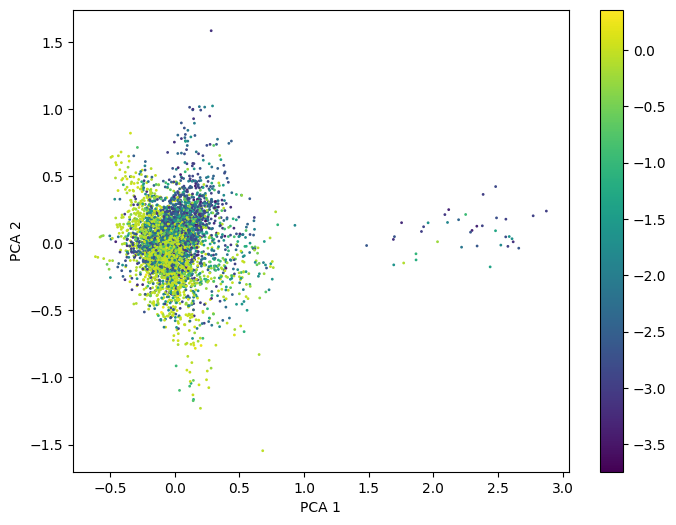

In [11]:
n_components = 2
pca = PCA(n_components=n_components)
PCAs = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(PCAs[:, 0], PCAs[:, 1], c=target, cmap='viridis', s=1)
plt.colorbar()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.savefig('results/pca_plots/PCA_BLAT_ECOLX_Ranganathan2015_esm2_150M_layer_30_iDCT2.png')
plt.show()

In [12]:
embed = pd.DataFrame(pd.read_pickle('embeddings/BLAT_ECOLX_Ranganathan2015_esm2_150M_compressed/embed_layer_30_mean.pkl')).T
#embed = pd.DataFrame(pd.read_pickle('embeddings/PABP_YEAST_Fields2013_doubles_esm2_150M_compressed/embed_layer_30_mean.pkl')).T
embed.reset_index(inplace=True)
embed.rename(columns={'index': 'ID'}, inplace=True)


data = metadata.merge(embed, on='ID')

features = data.iloc[:, metadata.shape[1]:]
target = data['target']

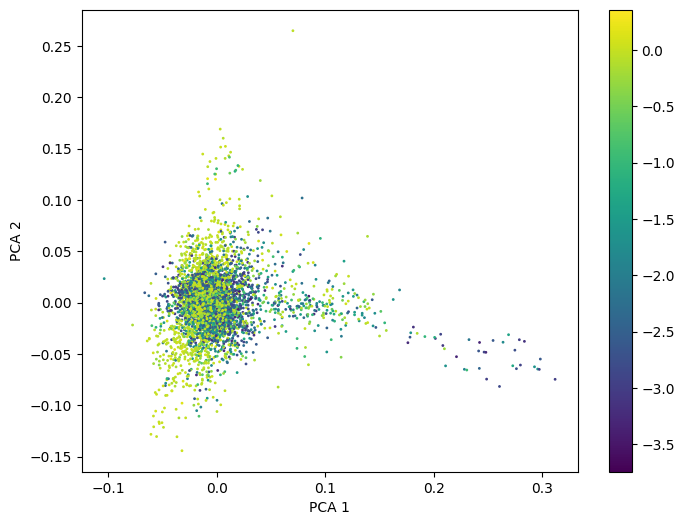

In [13]:
n_components = 2
pca = PCA(n_components=n_components)
PCAs = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(PCAs[:, 0], PCAs[:, 1], c=target, cmap='viridis', s=1)
plt.colorbar()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.savefig('results/pca_plots/PCA_BLAT_ECOLX_Ranganathan2015_esm2_150M_layer_30_mean.png')
plt.show()

In [14]:
stop

NameError: name 'stop' is not defined

In [ ]:
res = pd.read_csv('results/summary_DMS_15B.csv', index_col=0)
res

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd,Dataset
0,Lasso,1,0.848794,0.352045,0.447067,0.783350,0.422454,0.543479,0.910386,0.871133,861,mean,BLAT_Ran
1,Lasso,2,0.848814,0.352424,0.448037,0.760545,0.439828,0.559893,0.910618,0.872180,854,mean,BLAT_Ran
2,Lasso,3,0.851440,0.350521,0.444617,0.758985,0.441554,0.556303,0.910982,0.873762,856,mean,BLAT_Ran
3,Lasso,4,0.851023,0.350362,0.445274,0.753765,0.432569,0.561841,0.910920,0.871759,851,mean,BLAT_Ran
4,Lasso,5,0.848372,0.351659,0.447539,0.771579,0.435401,0.559210,0.910880,0.874358,857,mean,BLAT_Ran
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,Lasso,6,0.692226,0.119751,0.169190,0.641582,0.134589,0.173531,0.846529,0.805915,371,iDCT,RASH_HUMAN
6,Lasso,7,0.694682,0.120150,0.169027,0.602967,0.129455,0.177035,0.850895,0.753902,367,iDCT,RASH_HUMAN
7,Lasso,8,0.693445,0.118583,0.167837,0.597276,0.148995,0.194974,0.849197,0.760744,377,iDCT,RASH_HUMAN
8,Lasso,9,0.689884,0.120231,0.169719,0.625756,0.138177,0.177074,0.847419,0.786252,362,iDCT,RASH_HUMAN


<Axes: xlabel='R2_score_test', ylabel='Dataset'>

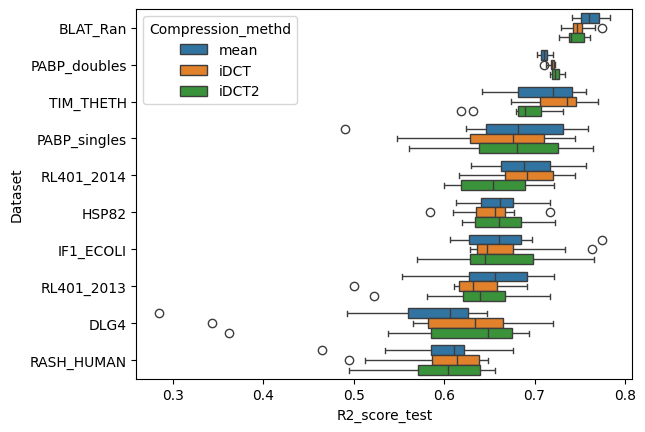

In [ ]:
sns.boxplot(data=res, y='Dataset', x='R2_score_test', hue='Compression_methd')